### TODO: ###
- Implement additional bonus score features:
    - Full clear
    - Combos
- Select NN type

In [2]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Gym
import gym
# import gym_pygame

# Hugging Face Hub
# from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.
import imageio

In [3]:
env_id = "gym_tetris:tetris_rl"
env = gym.make(env_id, render_mode='none')
eval_env = gym.make(env_id, render_mode='rgb_array')
s_size = env.observation_space.shape
a_size = env.action_space.n

Build Tetris v2.0
Build Tetris v2.0


/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [5]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action

print(env.observation_space.shape)

_____OBSERVATION SPACE_____ 

The State Space is:  (1, 29, 10)
Sample observation [[[1.5397036  0.06343687 1.8872619  1.382159   1.0473682  1.9251984
   0.897264   0.08528348 0.9151433  1.4723036 ]
  [1.4595941  0.9403704  0.12845424 0.24668245 0.98228955 1.810586
   0.5658485  1.5171816  1.3840156  0.8950672 ]
  [1.8609204  1.2891196  0.01590791 0.4629989  1.9793016  1.2563976
   1.5024828  0.20838559 1.572939   1.253561  ]
  [1.827416   1.747668   0.00356866 1.1272912  0.85146224 0.87206817
   1.6508422  0.76265657 0.65587723 1.434788  ]
  [1.6952497  0.44505724 0.95580584 1.6327839  0.19105239 0.4629011
   1.5527922  1.4278998  0.6794224  1.7080076 ]
  [0.02124046 0.61270976 1.5144837  1.8331058  0.5035843  0.05569146
   1.9102182  0.05203543 1.4397836  0.18588194]
  [1.2594516  1.0238037  0.9037286  1.3967718  1.0813528  1.5491322
   0.53656226 1.7995676  1.7281747  0.10986555]
  [1.6532967  1.4513876  0.25945222 0.21618292 1.2332275  1.4411674
   1.1680328  0.46649566 0.08648942 0

In [6]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size, h2_size):
        super(Policy, self).__init__()

        # Convolutional Network
        # self.conv = nn.Sequential(nn.Conv2d(s_size[0], h_size, 4), nn.ReLU(),
        #     nn.Conv2d(h_size, h_size, kernel_size=3, stride=1),nn.ReLU())
        # # print(self.conv(torch.zeros(1,*s_size,4)).size())
        # self.fc = nn.Sequential(
        #     nn.Linear(int(np.prod(self.conv(torch.zeros(1,*s_size)).size())), h2_size),
        #     nn.ReLU(),
        #     nn.Linear(h2_size, a_size)
        # )

        # Linear Network
        self.fc1 = nn.Linear(np.prod(s_size), h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, a_size)

        

    def forward(self, x):
        # Convlutional Network
        # x = self.conv(x).view(x.size()[0], -1)
        # x = self.fc(x)

        # Linear Network
        x = np.reshape(x,(1,-1))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        # print(np.shape(x))
        # We output the softmax
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [7]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    # Line 3 of pseudocode
    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Line 4 of pseudocode
        for t in range(max_t):
            action, log_prob = policy.act(state) # Code Here: get the action
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Line 6 of pseudocode: calculate the return
        returns = deque(maxlen=max_t)
        n_steps = len(rewards)

        # Compute the discounted returns at each timestep,
        # as the sum of the gamma-discounted return at time t (G_t) + the reward at time t

        ## We compute this starting from the last timestep to the first, to avoid redundant computations

        ## appendleft() function of queues appends to the position 0
        ## We use deque instead of lists to reduce the time complexity

        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft(gamma*disc_return_t + rewards[t]) # Code Here: complete here

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Line 7:
        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        # Line 8: PyTorch prefers gradient descent
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [11]:
hyperparameters = {
    "h_size": 64,
    "h2_size": 512,
    "n_training_episodes": 50000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.99,
    "lr": 1e-4,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [9]:
# Create policy and place it to the device
torch.manual_seed(50) # Don't change this
tetris_policy = Policy(hyperparameters["state_space"], hyperparameters["action_space"], hyperparameters["h_size"], hyperparameters["h2_size"]).to(device)
tetris_optimizer = optim.Adam(tetris_policy.parameters(), lr=hyperparameters["lr"])

In [12]:
scores = reinforce(tetris_policy,
                   tetris_optimizer,
                   hyperparameters["n_training_episodes"],
                   hyperparameters["max_t"],
                   hyperparameters["gamma"],
                   100)

/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri

Episode 100	Average Score: 0.00
Episode 200	Average Score: -0.19
Episode 300	Average Score: 0.01
Episode 400	Average Score: 0.13
Episode 500	Average Score: -0.33
Episode 600	Average Score: -0.41
Episode 700	Average Score: 0.06


KeyboardInterrupt: 

In [1]:
# Saving current policy for continued training
from time import gmtime, strftime
curr_time = strftime("%Y.%m.%d-%H.%M.%S", gmtime())
training_state = {'model':tetris_policy.state_dict(), 'optimizer':tetris_optimizer.state_dict()}
torch.save(training_state, f'./training_state_{curr_time}.data')

NameError: name 'tetris_policy' is not defined

In [13]:
# Loading existing policy
state = torch.load('./training_state_2023.12.07-11.04.44.data')
tetris_optimizer.load_state_dict(state['optimizer'])
tetris_policy.load_state_dict(state['model'])

<All keys matched successfully>

In [17]:
file = open('./training_scores_200k.txt','w')
for item in scores:
	file.write(f'{item} ')
file.write('\n')
file.flush()
file.close()

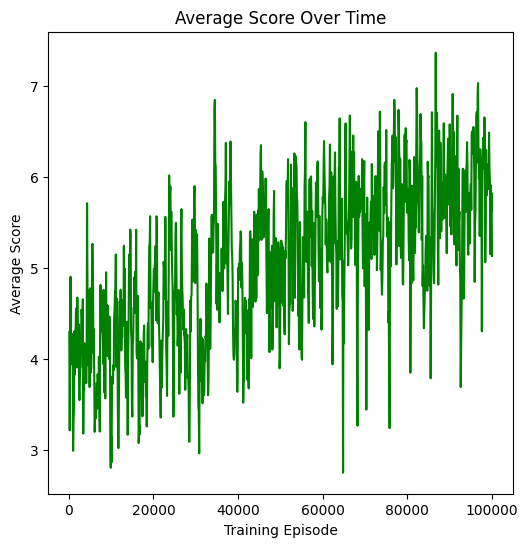

In [19]:
figure, axes = plt.subplots(1, figsize=(6, 6))

### YOUR CODE STARTS HERE ###
    
axes.set_title('Average Score Over Time')
axes.set_xlabel('Training Episode')
axes.set_ylabel('Average Score')
count = len(scores)//100
axes.plot(range(100,len(scores)+1,100), [np.mean(scores[100*i:100*i+100]) for i in range(count)], color = 'green')

In [14]:
def record_video(env, policy, out_directory, fps=30):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  done = False
  state = env.reset()
  img = env.render()
  images.append(img)
  for frame in range(5000):
    if done:
      break
    # Take the action (index) that have the maximum expected future reward given that state
    action, _ = policy.act(state)
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [15]:
from time import gmtime, strftime
curr_time = strftime("%Y.%m.%d-%H.%M.%S", gmtime())
record_video(eval_env, tetris_policy, f'./replay_{curr_time}.mp4')

/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/ai/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is wri